In [1]:
# General
import numpy as np
import pandas as pd
import os
import jumpmodels.utils

# For loading data and feature engineering
from feature_25 import DataLoader, MergedDataLoader

# For data prep and pre-processing
from jumpmodels.utils import filter_date_range 
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd 

# For model fit and prediction
from joblib import Parallel, delayed # allows parallel grid search on all 4 cores
from jumpmodels.sparse_jump import SparseJumpModel

# For plotting
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret
import matplotlib.pyplot as plt

In [2]:
import importlib
import feature_25 
importlib.reload(feature_25)


<module 'feature_25' from 'c:\\Users\\victo\\0_thesis_repo\\thesis_vri_vp\\victor\\feature_25.py'>

In [3]:
# Import data
# -------------------------

# Define file path
directory = r"C:\Users\victo\0_thesis_repo\thesis_vri_vp\data"
factor_file = os.path.join(directory, "factor_data.csv")
market_file = os.path.join(directory, "market_data.csv")

# Use DataLoader to generate features when we use factor and market data
data = MergedDataLoader(
    factor_file=factor_file,
    market_file=market_file,
    ver="v2",
    factor_col="VLUE"  # specify which column in factor_data.csv is your factor return
).load(start_date="2002-05-31", end_date="2025-02-24")

# Ensure all attributes have the same index before filtering
common_index = data.X.index.intersection(data.ret_ser.index).intersection(data.market_ser.index)
data.X = data.X.loc[common_index]
data.ret_ser = data.ret_ser.loc[common_index]
data.market_ser = data.market_ser.loc[common_index]

# Identify and drop dates where returns are exactly 0.0
zero_return_dates = data.ret_ser[data.ret_ser == 0.0].index

# Drop from all attributes to maintain alignment
data.X = data.X.drop(zero_return_dates, errors='ignore')
data.ret_ser = data.ret_ser.drop(zero_return_dates, errors='ignore')
data.market_ser = data.market_ser.drop(zero_return_dates, errors='ignore')  # Ensure market returns match


# print("Daily returns:", data.ret_ser)
# print("Engineered features:", data.X)

# factor_data = pd.read_csv(factor_file, parse_dates=["Date"], index_col="Date")

# Plot cumulative returns
# plot_cumret(factor_data["IWF"])
# plt.show()


In [4]:
# Train/test split
# -------------------------

train_start, test_start = "2002-05-31", "2022-01-01" #actual start date of training will be in August due to 63 trading days required for EWMA
# filter dates
X_train = filter_date_range(data.X, start_date=train_start, end_date=test_start)
X_test = filter_date_range(data.X, start_date=test_start)
# print time split
train_start, train_end = X_train.index[[0, -1]]
test_start, test_end = X_test.index[[0, -1]]
print("Training starts at:", train_start, "and ends at:", train_end)
print("Testing starts at:", test_start, "and ends at:", test_end)

# Preprocessing
# -------------------------

# Clip the data within 3 standard deviations to mitigate the impact of outliers and standardize the clipped data (zero mean and unit variance)
clipper = DataClipperStd(mul=3.)
scalar = StandardScalerPD()
# fit on training data
X_train_processed = scalar.fit_transform(clipper.fit_transform(X_train))
# transform the test data
X_test_processed = scalar.transform(clipper.transform(X_test))

Training starts at: 2002-08-28 00:00:00 and ends at: 2021-12-31 00:00:00
Testing starts at: 2022-01-03 00:00:00 and ends at: 2025-02-24 00:00:00


In [5]:
def rolling_window_cv_sjm_long_short(
    lam, kappa, 
    X, 
    factor_returns, 
    market_returns, 
    n_splits=5, 
    min_train_size=5*252,
    cost_per_100pct=0.0005,  # 5 bps cost per 100% turnover
    annual_threshold=0.05    # ±5% annual threshold
):
    """
    Perform rolling expanding-window cross-validation, re-fitting the SparseJumpModel
    monthly within each validation window (Shu et al. 2025 style).
    
    """
    
    # Force alignment among X, factor_returns, and market_returns
    common_idx = X.index.intersection(factor_returns.index).intersection(market_returns.index)
    X = X.loc[common_idx].sort_index()
    factor_returns = factor_returns.loc[common_idx].sort_index()
    market_returns = market_returns.loc[common_idx].sort_index()

    split_size = (len(X) - min_train_size) // n_splits
    max_feats = int(kappa**2)

    def position_from_expected_return(ann_ret):
        if ann_ret > annual_threshold:
            return 1.0
        elif ann_ret < -annual_threshold:
            return -1.0
        else:
            return ann_ret / annual_threshold

    sharpe_scores = []

    # Initialize model once before looping
    model = SparseJumpModel(
        n_components=2,
        max_feats=max_feats,
        jump_penalty=lam,
        cont=False,
        max_iter=30
    )

    for fold_i in range(n_splits):
        train_end = min_train_size + fold_i * split_size
        
        X_train_cv = X.iloc[:train_end]
        y_train_cv = factor_returns.iloc[:train_end]
        m_train_cv = market_returns.iloc[:train_end]

        X_val_cv = X.iloc[train_end:]
        y_val_cv = factor_returns.iloc[train_end:]
        m_val_cv = market_returns.iloc[train_end:]

        val_idx = X_val_cv.index.intersection(y_val_cv.index).intersection(m_val_cv.index)
        X_val_cv = X_val_cv.loc[val_idx]
        y_val_cv = y_val_cv.loc[val_idx]
        m_val_cv = m_val_cv.loc[val_idx]

        if len(X_val_cv) == 0:
            sharpe_scores.append(0.0)
            continue

        model.fit(X_train_cv, y_train_cv, sort_by="cumret")
        
        val_index = X_val_cv.index
        val_month_starts = pd.date_range(
            start=val_index[0].to_period('M').to_timestamp(), 
            end=val_index[-1],
            freq='MS'
        )
        val_month_starts = val_month_starts[val_month_starts <= val_index[-1]]
        val_month_starts = list(val_month_starts)

        prev_position = 0.0
        daily_returns = []

        for month_i, month_start in enumerate(val_month_starts):
            if month_i < len(val_month_starts) - 1:
                next_m = val_month_starts[month_i + 1]
                month_end = next_m - pd.Timedelta(days=1)
            else:
                month_end = val_index[-1]

            sub_mask = (val_index >= month_start) & (val_index <= month_end)
            if not sub_mask.any():
                continue

            refit_end = month_start - pd.Timedelta(days=1)
            X_refit = X.loc[:refit_end]
            y_refit = factor_returns.loc[:refit_end]
            m_refit = market_returns.loc[:refit_end]

            if len(X_refit) > 0:
                model.set_params(jump_penalty=lam, max_feats=max_feats)
                model.fit(X_refit, y_refit, sort_by="cumret")

            state_avg_daily_ret = model.ret_
            avg_mkt_daily_ret = m_refit.mean() if len(m_refit) > 0 else 0.0

            state_to_expected = {
                st: (state_avg_daily_ret[st] - avg_mkt_daily_ret)*252
                for st in range(len(state_avg_daily_ret))
            }

            X_sub = X_val_cv.loc[sub_mask]
            y_sub = y_val_cv.loc[sub_mask]
            m_sub = m_val_cv.loc[sub_mask]

            if len(X_sub) == 0:
                continue

            sub_states = model.predict_online(X_sub)
            
            for day_i, day in enumerate(X_sub.index):
                st = sub_states[day_i]
                exp_ann_ret = state_to_expected.get(st, 0.0)
                position = position_from_expected_return(exp_ann_ret)

                turnover = abs(position - prev_position)*2.0
                cost = turnover*cost_per_100pct

                daily_pnl = position * (y_sub.loc[day] - m_sub.loc[day])
                daily_net = daily_pnl - cost

                daily_returns.append(daily_net)
                prev_position = position

        daily_returns = np.array(daily_returns)
        if len(daily_returns) < 2:
            sharpe_scores.append(0.0)
            continue
        
        avg_ret = daily_returns.mean()
        std_ret = daily_returns.std(ddof=1)
        val_sharpe = (avg_ret/std_ret)*np.sqrt(252) if std_ret > 0 else 0.0
        sharpe_scores.append(val_sharpe)

    return np.mean(sharpe_scores)



# Example usage in parallel cross-validation:
lambda_values = np.logspace(-1, 3, 10)  # Generate λ values from 1 to 100
kappa_values  = np.linspace(2, np.sqrt(X_train_processed.shape[1]), 3)  # Generate κ values

# Assign market return series
market_ser = data.market_ser  # Ensure market returns are aligned with factor returns

# Perform cross-validation in parallel using joblib
results = Parallel(n_jobs=4)(
    delayed(rolling_window_cv_sjm_long_short)(
        lam, kappa, 
        X_train_processed, 
        factor_returns=data.ret_ser, 
        market_returns=market_ser
    )
    for lam in lambda_values  # Iterate over lambda values
    for kappa in kappa_values  # Iterate over kappa values
)

# Identify the best lambda and kappa combination
best_index = np.argmax(results)  # Find index of max Sharpe ratio
best_lambda = lambda_values[best_index // len(kappa_values)]  # Extract corresponding lambda
best_kappa = kappa_values[best_index % len(kappa_values)]  # Extract corresponding kappa
max_feats_best = int(best_kappa**2)  # Compute best max features

# Print optimal hyperparameters
print(f"Best Jump Penalty (λ): {best_lambda}")
print(f"Best Max Features (κ²): {max_feats_best}")


KeyboardInterrupt: 

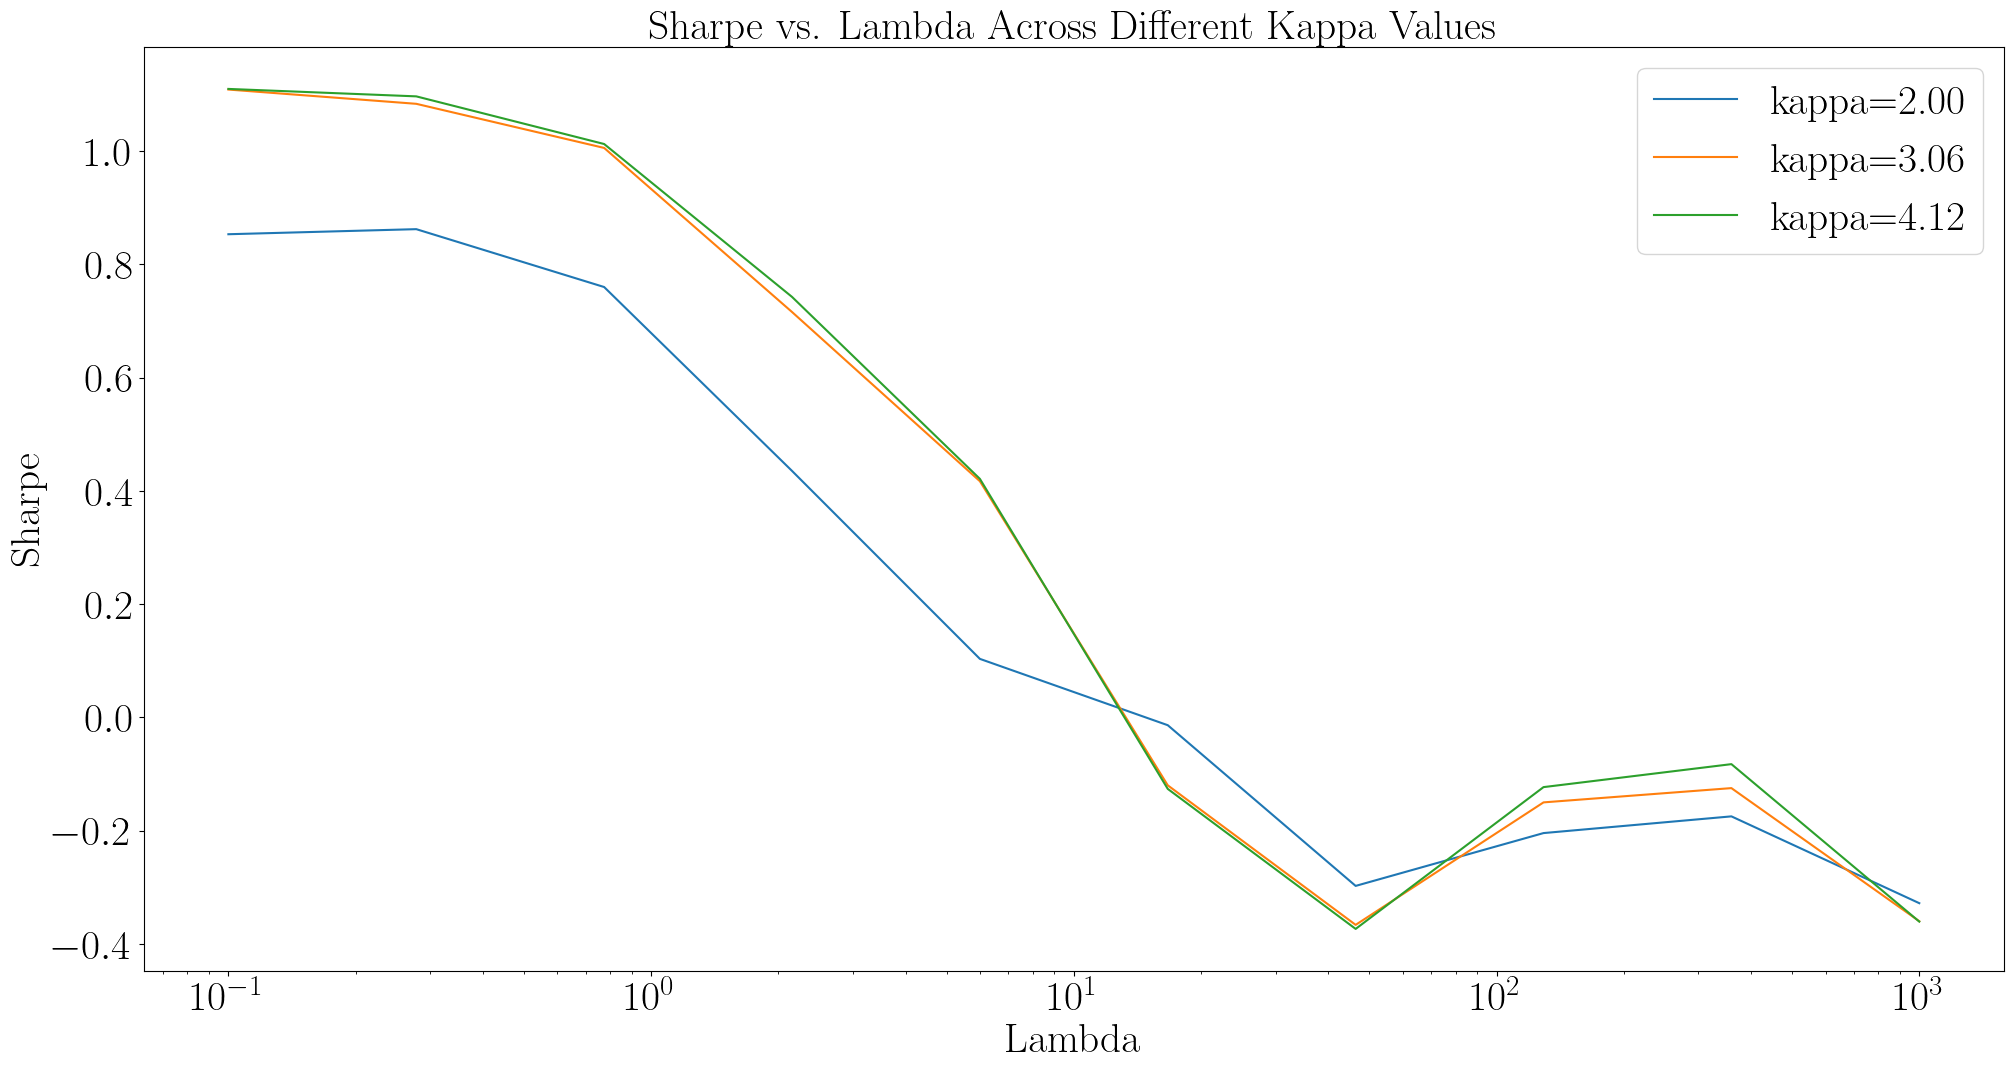

In [ ]:
# Reshape so that rows correspond to each lambda and columns correspond to each kappa
results_array = np.array(results).reshape(len(lambda_values), len(kappa_values))

plt.figure()
for i, kappa in enumerate(kappa_values):
    plt.plot(lambda_values, results_array[:, i], label=f"kappa={kappa:.2f}")

plt.xscale('log')  # Because lambda_values came from logspace
plt.xlabel('Lambda')
plt.ylabel('Sharpe')
plt.title('Sharpe vs. Lambda Across Different Kappa Values')
plt.legend()
plt.show()

In [ ]:
# -------------------------
# Fit the Sparse Jump Model
# -------------------------


# **Final Model Training with Best (λ, κ) Values**
best_model = SparseJumpModel(n_components=2, max_feats=max_feats_best, jump_penalty=best_lambda, cont=False, max_iter=30)
best_model.fit(X_train_processed, data.ret_ser, sort_by="cumret")



SparseJumpModel(jump_penalty=0.1, max_feats=17)

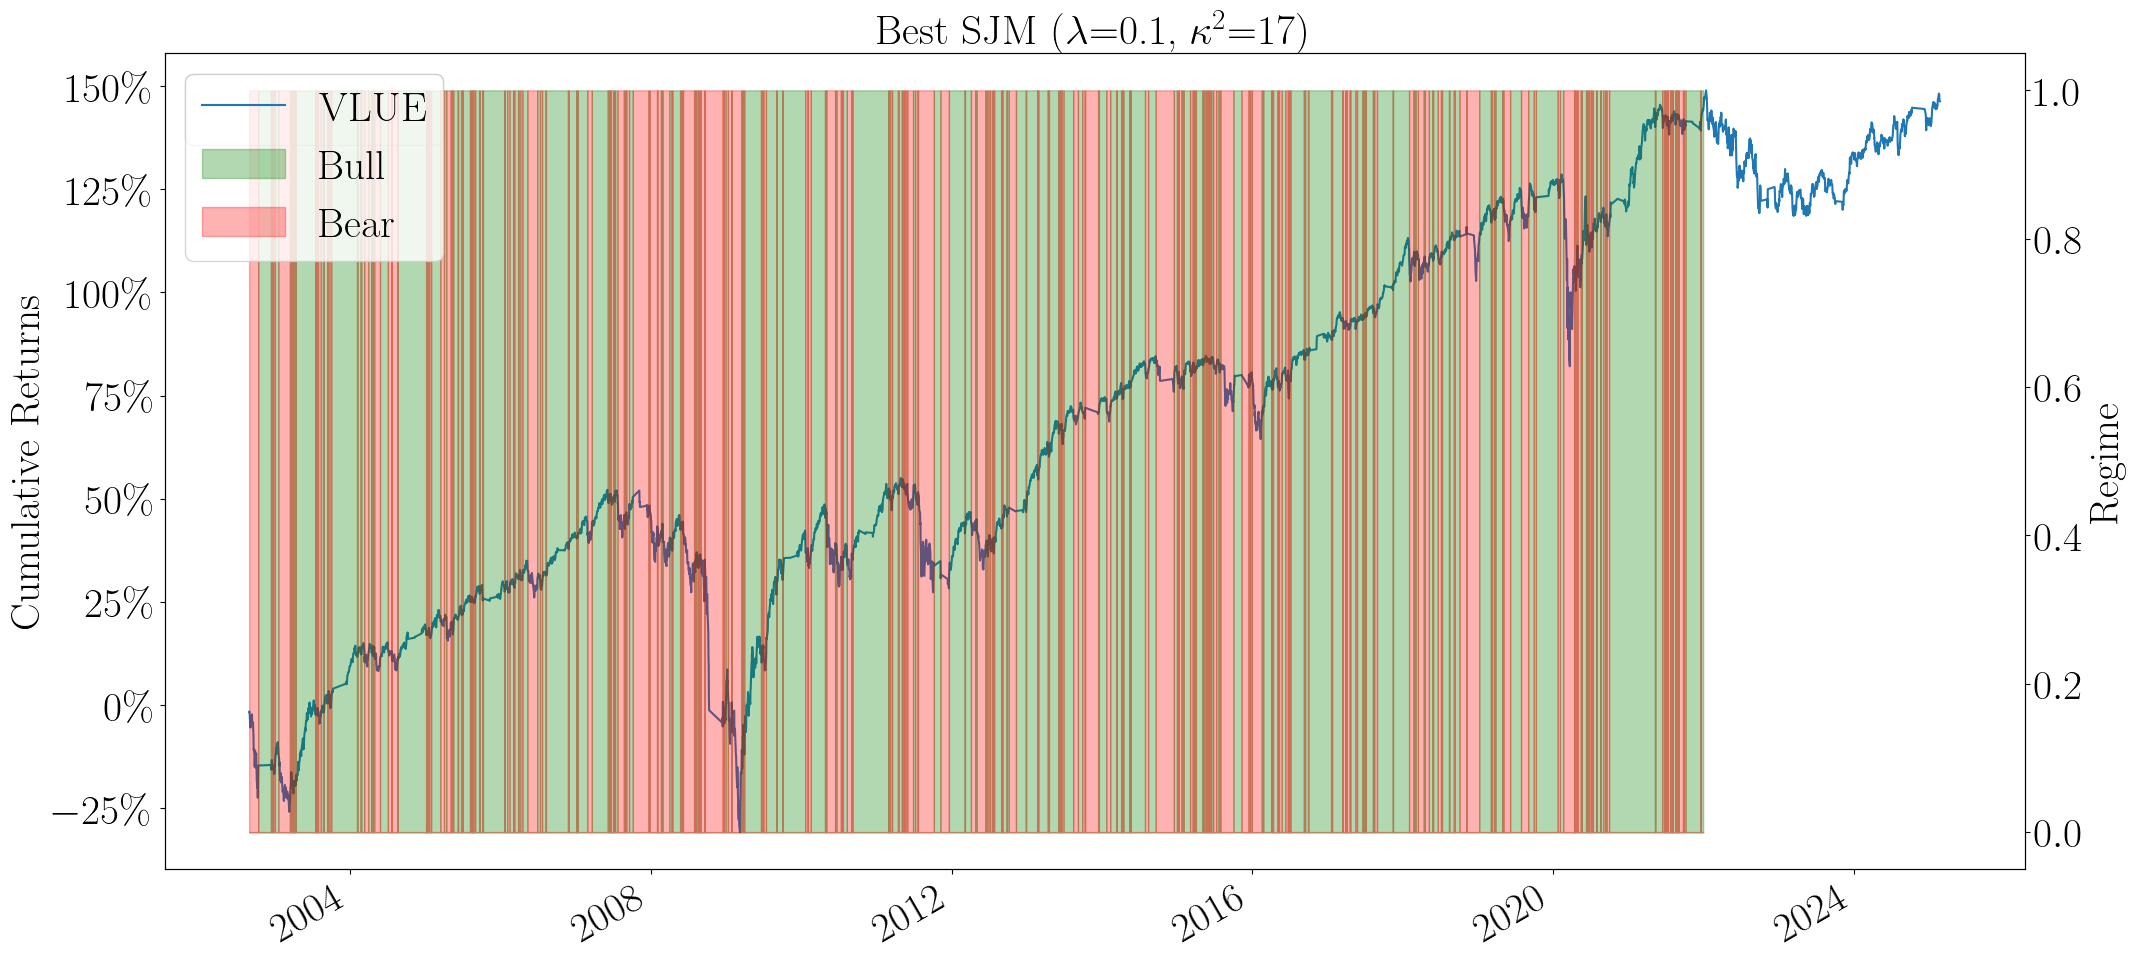

In [ ]:
# **Predict and Plot Results**

# factor_data = pd.read_csv(factor_file, parse_dates=["Date"], index_col="Date")

predicted_states = best_model.predict(X_train_processed)

# print(predicted_states.head())
# print(factor_data["VLUE"].head())
# print(predicted_states.tail())
# print(factor_data["VLUE"].tail())

ax, ax2 = plot_regimes_and_cumret(predicted_states, data.ret_ser)
ax.set(title=f"Best SJM ($\\lambda$={best_lambda}, $\\kappa^2$={max_feats_best})")
plt.show()

In [ ]:
# Predict the states on the in-sample data
print("Predicted states (in-sample):")
print(predicted_states)

# Print the feature weights (sparse weights)
print("SJM Feature Weights:")
print(best_model.feat_weights)

Predicted states (in-sample):
Date
2002-08-28    1
2002-08-29    1
2002-08-30    1
2002-09-03    1
2002-09-04    1
             ..
2021-12-27    0
2021-12-28    0
2021-12-29    0
2021-12-30    0
2021-12-31    0
Length: 3988, dtype: int64
SJM Feature Weights:
ActiveReturn_EWMA_8         0.324946
ActiveReturn_EWMA_21        0.330279
ActiveReturn_EWMA_63        0.270288
RSI_8                       0.552866
RSI_21                      0.602954
RSI_63                      0.466790
StochOsc_%K_8               0.510222
StochOsc_%K_21              0.701878
StochOsc_%K_63              0.651946
MACD_8_21                   0.363515
MACD_21_63                  0.162524
DownsideDev_log_21          0.142667
ActiveMarketBeta_EWMA_21    0.019988
MarketReturn_EWMA_21        0.566287
VIX_log_diff_EWMA_21        0.537823
2Y_diff_EWMA_21             0.218600
10Y-2Y_EWMA_21              0.089909
dtype: float64


In [ ]:
# # check constraints

# w = best_model.feat_weights ** 2
# l1 = w.sum()
# l2 = np.sqrt((w**2).sum())

# print("L1 norm =", l1)
# print("L2 norm =", l2)
# print("Expected L1 (≈ kappa):", np.sqrt(best_model.max_feats))

w_internals = best_model.w  # The internal lasso vector

l1_w = w_internals.sum()
l2_w = np.sqrt((w_internals**2).sum())

print("L1 norm of w_internals =", l1_w)
print("L2 norm of w_internals =", l2_w)
print("Expected L1 (≈ kappa) =", np.sqrt(best_model.max_feats))

L1 norm of w_internals = 3.1979440424974164
L2 norm of w_internals = 0.9999999999999999
Expected L1 (≈ kappa) = 4.123105625617661


In [ ]:
# print("\n\n".join(In[i] for i in range(1, len(In))))
# check constraints


In [ ]:
#jupyter nbconvert --to script sparseJM_sharpe_crossval_v2.ipynb